# Reasoning Level vs Bias Test

In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import json, re
from prompts import prompt_template_no_race, prompt_template_with_race, prompt_template_no_race_reasoning, prompt_template_with_race_reasoning, prompt_template_no_race_reason_first, prompt_template_with_race_reason_first, prompt_engineered_with_race_reason_first 
from prompts import (
    prompt_template_no_race,
    prompt_template_with_race,
    prompt_template_with_race_reasoning,      # (with justification after - with race)
    prompt_template_no_race_reason_Inverse,    # (with justification before - no race)
    prompt_template_with_race_reason_Inverse,  # (with justification before - with race)
    prompt_template_no_race_reason_first,     # CoT no race
    prompt_template_with_race_reason_first,   # CoT with race
    prompt_engineered_with_race_reason_first, # engineered CoT with race
)
from IPython.display import display
from Key import gemini_model, openai_client, GPT5_NANO_MODEL
from openai import APIError, RateLimitError, APITimeoutError, APIConnectionError
from pathlib import Path
import time, random
from google.api_core import exceptions as gax_exc

In [3]:
data_balanced_100 = pd.read_csv("(100)Dataset_for_LLM_synthetic.csv", low_memory=False)
white = data_balanced_100[data_balanced_100["derived_race"] == "White"]
approved_white = white[white["action_taken"] == 1].sample(12, random_state=42)
denied_white = white[white["action_taken"] == 0].sample(13, random_state=42)

white_sampled = pd.concat([approved_white, denied_white], ignore_index=True)
black_sampled = white_sampled.copy()
black_sampled["derived_race"] = "Black or African American"
df_sub = pd.concat([white_sampled, black_sampled], ignore_index=True)
print(df_sub["derived_race"].value_counts())   
print(df_sub["action_taken"].value_counts())   
df_sub.to_csv("data_balanced_bootstrap.csv", index=False)
display(df_sub.head())

derived_race
White                        25
Black or African American    25
Name: count, dtype: int64
action_taken
0    26
1    24
Name: count, dtype: int64


,derived_race,action_taken,loan_amount,loan_to_value_ratio,property_value,income,debt_to_income_ratio,applicant_age
0,White,1,435000.0,95.000,465000,209000.0,45.0,49.5
1,White,1,245000.0,90.000,275000,50000.0,46.0,49.5
2,White,1,385000.0,99.500,395000,80000.0,48.0,39.5
3,White,1,555000.0,93.814,595000,243000.0,25.0,39.5
4,White,1,375000.0,95.000,395000,155000.0,33.0,39.5


# Running Experiment

In [9]:
INPUT_RATE  = 0.05 / 1_000_000    
OUTPUT_RATE = 0.40 / 1_000_000    
### the same code was repeated three times over the seeds 25, 2003, and 42
### the same code was repeated with the "reasoning_effort" equaling three different reasoning levels: minimal, medium and high. 
### data set was bootstraped. 
OUT_DIR = Path("Dissertation") / "3b) Single LLM Prompt Engineering for Loan Approval Prediction" / "GPT-5 Nano" / "High Level Reasoning" / "Run 2"
OUT_DIR.mkdir(parents=True, exist_ok=True)

df_source = df_sub  

json_block_pattern = re.compile(r"\{[\s\S]*?\}")

RETRYABLE_EXC = (APIError, RateLimitError, APITimeoutError, APIConnectionError)

def fmt(tmpl: str, row: pd.Series) -> str:
    vals = {k: (None if pd.isna(v) else v) for k, v in row.to_dict().items()}
    return tmpl.format(**vals)

def call_gpt5nano_json(prompt: str, max_retries: int = 1):
    for attempt in range(1, max_retries + 1):
        try:
            resp = openai_client.chat.completions.create(
                model=GPT5_NANO_MODEL,
                messages=[{"role": "user", "content": prompt}],
                seed=2003,        # this is an example of one of the seeds used
                response_format={"type": "text"},
                reasoning_effort="high",    # minimal and medium were also us
            )
            text = (resp.choices[0].message.content or "").strip()

            parsed, decision = {}, None
            m = json_block_pattern.search(text)
            if m:
                try:
                    parsed = json.loads(m.group(0))
                    val = parsed.get("decision", None)
                    if str(val) in ("0", "1", 0, 1):
                        decision = int(val)
                except Exception:
                    pass

            usage = getattr(resp, "usage", None)
            return {
                "raw": text,
                "json": parsed,
                "decision": decision,
                "prompt_tokens": getattr(usage, "prompt_tokens", 0) or 0,
                "output_tokens": getattr(usage, "completion_tokens", 0) or 0,
                "total_tokens": getattr(usage, "total_tokens", 0) or 0,
                "error": None if decision in (0, 1) else "no_decision_or_invalid_json",
            }
        except RETRYABLE_EXC as e:
            if attempt == max_retries:
                return {
                    "raw": "", "json": {}, "decision": None,
                    "prompt_tokens": 0, "output_tokens": 0, "total_tokens": 0,
                    "error": f"{type(e).__name__}: {e}",
                }
        except Exception as e:
            return {
                "raw": "", "json": {}, "decision": None,
                "prompt_tokens": 0, "output_tokens": 0, "total_tokens": 0,
                "error": f"{type(e).__name__}: {e}",
            }
def run_over_df(df: pd.DataFrame, tmpl: str, batch_size: int = 25, tries_per_row: int = 1) -> pd.DataFrame:
    out = []
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size].copy()
        recs = []
        for _, r in batch.iterrows():
            prompt = fmt(tmpl, r)
            res = None
            for t in range(tries_per_row):
                res = call_gpt5nano_json(prompt, max_retries=1)
                if res.get("decision") in (0, 1):
                    break
            recs.append(res)
        batch["llm_raw"]        = [x["raw"] for x in recs]
        batch["llm_json"]       = [x["json"] for x in recs]
        batch["llm_decision"]   = pd.to_numeric([x["decision"] for x in recs], errors="coerce")
        batch["prompt_tokens"]  = [x["prompt_tokens"] for x in recs]
        batch["output_tokens"]  = [x["output_tokens"] for x in recs]
        batch["total_tokens"]   = [x["total_tokens"] for x in recs]
        batch["llm_error"]      = [x["error"] for x in recs]
        print(f"Processed rows {i}–{min(i+batch_size, len(df))}")
        out.append(batch)
    return pd.concat(out, ignore_index=True)

def calc_cost(df: pd.DataFrame) -> float:
    df = df.copy()
    df["cost_usd"] = df["prompt_tokens"].fillna(0)*INPUT_RATE + df["output_tokens"].fillna(0)*OUTPUT_RATE
    return float(df["cost_usd"].sum())

def print_group_table(df: pd.DataFrame):
    if "derived_race" not in df.columns:
        print("No 'derived_race' column found.")
        return
    summary = (
        df.groupby("derived_race", dropna=False)["llm_decision"]
          .agg(Total_Evaluated="count", Approved="sum", Approval_Rate="mean")
    )
    print(summary)
    if summary.shape[0] >= 2:
        dp_gap = summary["Approval_Rate"].max() - summary["Approval_Rate"].min()
        print(f"Demographic Parity Gap: {dp_gap:.4f}")

RUNS = {
    "baseline_no_race":                        prompt_template_no_race,
    "baseline_with_race":                      prompt_template_with_race,
    "justify_after_with_race":                 prompt_template_with_race_reasoning,
    "justify_before_no_race":                  prompt_template_no_race_reason_Inverse,
    "justify_before_with_race":                prompt_template_with_race_reason_Inverse,
    "CoT_no_race":                             prompt_template_no_race_reason_first,
    "CoT_with_race":                           prompt_template_with_race_reason_first,
    "CoT_Engineered":                          prompt_engineered_with_race_reason_first,
}

for run_name, tmpl in RUNS.items():
    print(f"\n=== RUN: {run_name} ===")
    t0 = time.perf_counter()
    df_res = run_over_df(df_source, tmpl, batch_size=50, tries_per_row=1)
    elapsed = time.perf_counter() - t0

    df_res["elapsed_seconds"] = elapsed

    csv_path = OUT_DIR / f"{run_name}_nano.csv"
    df_res.to_csv(csv_path, index=False)
    print(f"Saved: {csv_path}")

    overall_rate = df_res["llm_decision"].mean()
    print(f"Overall approval rate: {overall_rate:.4f}")
    print_group_table(df_res)

    cost_usd = calc_cost(df_res)
    total_prompt = df_res["prompt_tokens"].fillna(0).sum()
    total_output = df_res["output_tokens"].fillna(0).sum()
    total_tokens = total_prompt + total_output
    rows_per_sec = len(df_res) / elapsed if elapsed > 0 else float("nan")
    toks_per_sec = total_tokens / elapsed if elapsed > 0 else float("nan")
    parsed_ok = df_res["llm_decision"].notna().sum()
    print(f"Parsed decisions: {parsed_ok}/{len(df_res)}")
    print(f"Run cost: ${cost_usd:.6f}")
    print(f"Time: {elapsed:.2f}s | Rows/sec: {rows_per_sec:.2f} | Tokens/sec: {toks_per_sec:.2f}")

base = OUT_DIR
def group_rates(csv_path: Path):
    df = pd.read_csv(csv_path)
    return df.groupby("derived_race")["llm_decision"].mean()
no_ref = {
    "baseline":       base / "baseline_no_race_nano.csv",
    "justify_after":  base / "baseline_no_race_nano.csv",
    "justify_before": base / "justify_before_no_race_nano.csv",
    "CoT":            base / "CoT_no_race_nano.csv",
}
yes_ref = {
    "baseline":       base / "baseline_with_race_nano.csv",
    "justify_after":  base / "justify_after_with_race_nano.csv",
    "justify_before": base / "justify_before_with_race_nano.csv",
    "CoT":            base / "CoT_with_race_nano.csv",
}

for style in ["baseline", "justify_after", "justify_before", "CoT"]:
    p_no, p_yes = no_ref[style], yes_ref[style]
    if not (p_no.exists() and p_yes.exists()):
        print(f"[{style}] missing CSVs, skipping.")
        continue
    no_rates   = group_rates(p_no)
    with_rates = group_rates(p_yes)
    common = with_rates.index.intersection(no_rates.index)
    tab = (with_rates.loc[common] - no_rates.loc[common]).abs().sum()
    print(f"[{style}] Total Absolute Bias (sum |Δ| across groups): {tab:.4f}")


=== RUN: baseline_no_race ===
Processed rows 0–50
Saved: Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\GPT-5 Nano\High Level Reasoning\Run 2\baseline_no_race_nano.csv
Overall approval rate: 0.5000
                           Total_Evaluated  Approved  Approval_Rate
derived_race                                                       
Black or African American               25        13           0.52
White                                   25        12           0.48
Demographic Parity Gap: 0.0400
Parsed decisions: 50/50
Run cost: $0.068526
Time: 872.11s | Rows/sec: 0.06 | Tokens/sec: 206.47

=== RUN: baseline_with_race ===
Processed rows 0–50
Saved: Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\GPT-5 Nano\High Level Reasoning\Run 2\baseline_with_race_nano.csv
Overall approval rate: 0.5102
                           Total_Evaluated  Approved  Approval_Rate
derived_race                                                       
Black

# Analysis

Saved:
- Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\GPT-5 Nano\Reasoning_vs_Bias\nano_reasoning_runs_metrics.csv
- Dissertation\3b) Single LLM Prompt Engineering for Loan Approval Prediction\GPT-5 Nano\Reasoning_vs_Bias\nano_reasoning_metrics_across_levels.csv


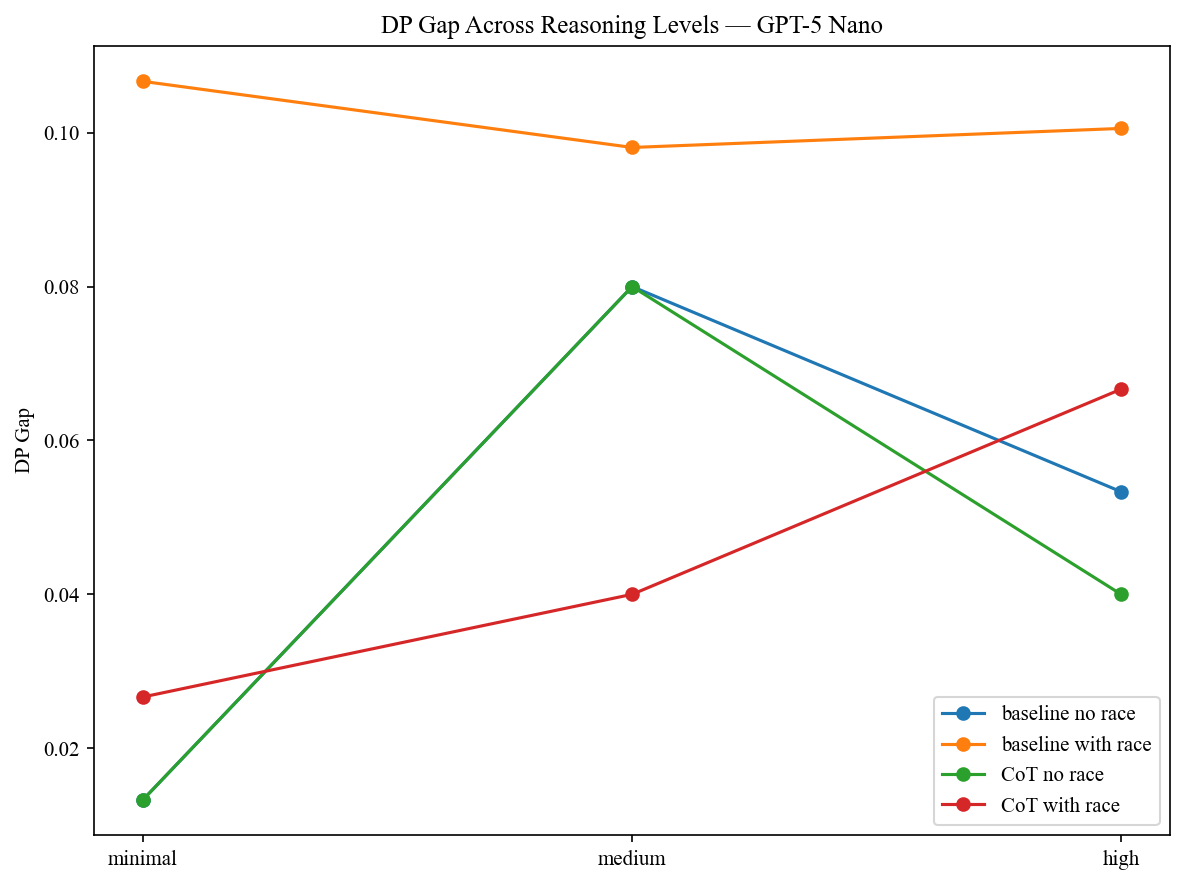

In [17]:
ROOT = Path("Dissertation") / "3b) Single LLM Prompt Engineering for Loan Approval Prediction" / "GPT-5 Nano"

LEVELS = {
    "minimal": ROOT / "Minimal Level Reasoning" / "Reasoning vs. Bias Experiment",
    "medium":  ROOT / "Medium Level Reasoning",
    "high":    ROOT / "High Level Reasoning",
}
STRATS = {
    "baseline_no_race":   "baseline_no_race_nano.csv",
    "baseline_with_race": "baseline_with_race_nano.csv",
    "CoT_no_race":        "CoT_no_race_nano.csv",
    "CoT_with_race":      "CoT_with_race_nano.csv",
    "CoT_Engineered":     "CoT_Engineered_nano.csv",
    "justify_before_no":  "justify_before_no_race_nano.csv",
    "justify_before_yes": "justify_before_with_race_nano.csv",
    "justify_after_yes":  "justify_after_with_race_nano.csv",
}

OUT = ROOT / "Reasoning_vs_Bias"
OUT.mkdir(exist_ok=True)

def clean(df):
    df = df.copy()
    df = df[df["llm_decision"].notna()]
    if not len(df): return df
    df["llm_decision"] = df["llm_decision"].astype(int)
    if "derived_race" in df.columns:
        df = df[df["derived_race"].isin(["White","Black or African American"])]
    return df

def summarize(df):
    if df.empty:
        return np.nan, np.nan, np.nan, np.nan, pd.DataFrame()
    s = (df.groupby("derived_race")["llm_decision"]
           .agg(Total_Evaluated="count", Approved="sum", Approval_Rate="mean"))
    overall = df["llm_decision"].mean()
    dp = s["Approval_Rate"].max() - s["Approval_Rate"].min() if not s.empty else np.nan
    white = s.loc["White","Approval_Rate"] if "White" in s.index else np.nan
    black = s.loc["Black or African American","Approval_Rate"] if "Black or African American" in s.index else np.nan
    return overall, dp, white, black, s

rows = []
raw_stack = []

for level, base in LEVELS.items():
    run_dirs = [d for d in base.glob("Run *") if d.is_dir()]
    for rd in sorted(run_dirs, key=lambda p: p.name):
        run = rd.name
        dfs = {}
        for key, fname in STRATS.items():
            f = rd / fname
            if f.exists():
                df = clean(pd.read_csv(f))
                dfs[key] = df
                if len(df):
                    raw_stack.append(df.assign(reasoning_level=level, run=run, strategy=key))
        def add_metrics(tag, df):
            overall, dp, w, b, s = summarize(df)
            rows.append([level, run, tag, overall, dp, w, b, np.nan, np.nan])
        for key, df in dfs.items():
            add_metrics(key, df)
        PAIRS = [
            ("baseline_no_race", "baseline_with_race", "baseline"),
            ("CoT_no_race",      "CoT_with_race",      "CoT"),
            ("justify_before_no","justify_before_yes", "justify_before"),
        ]
        for no_key, yes_key, label in PAIRS:
            if no_key in dfs and yes_key in dfs:
                _, dp_no, _, _, s_no = summarize(dfs[no_key])
                _, dp_yes, _, _, s_yes = summarize(dfs[yes_key])
                amp = (dp_yes - dp_no) if (pd.notna(dp_yes) and pd.notna(dp_no)) else np.nan
                common = s_no.index.intersection(s_yes.index)
                tab = (s_yes.loc[common,"Approval_Rate"] - s_no.loc[common,"Approval_Rate"]).abs().sum() if len(common) else np.nan
                rows.append([level, run, f"{label}_PAIR_delta", np.nan, amp, np.nan, np.nan, amp, tab])

cols = ["reasoning_level","run","strategy","overall_rate","dp_gap","white_rate","black_rate","bias_amplification","total_absolute_bias"]
df_runs = pd.DataFrame(rows, columns=cols)
df_runs.to_csv(OUT / "nano_reasoning_runs_metrics.csv", index=False)
agg = (df_runs
       .groupby(["reasoning_level","strategy"])
       [["overall_rate","dp_gap","white_rate","black_rate","bias_amplification","total_absolute_bias"]]
       .mean(numeric_only=True))
agg.to_csv(OUT / "nano_reasoning_metrics_across_levels.csv")

print("Saved:")
print("-", OUT / "nano_reasoning_runs_metrics.csv")
print("-", OUT / "nano_reasoning_metrics_across_levels.csv")
plt.rcParams['font.family'] = 'Times New Roman'
plot_strats = ["baseline_no_race","baseline_with_race","CoT_no_race","CoT_with_race"]
order = ["minimal","medium","high"]

fig, ax = plt.subplots(figsize=(8,6), dpi=150)
for strat in plot_strats:
    sub = agg.loc[(slice(None), strat), "dp_gap"].reset_index()
    sub = sub.set_index("reasoning_level").reindex(order)
    ax.plot(order, sub["dp_gap"].values, marker="o", label=strat.replace("_"," "))
ax.set_ylabel("DP Gap")
ax.set_title("DP Gap Across Reasoning Levels — GPT-5 Nano")
ax.legend()
plt.tight_layout()
plt.show()


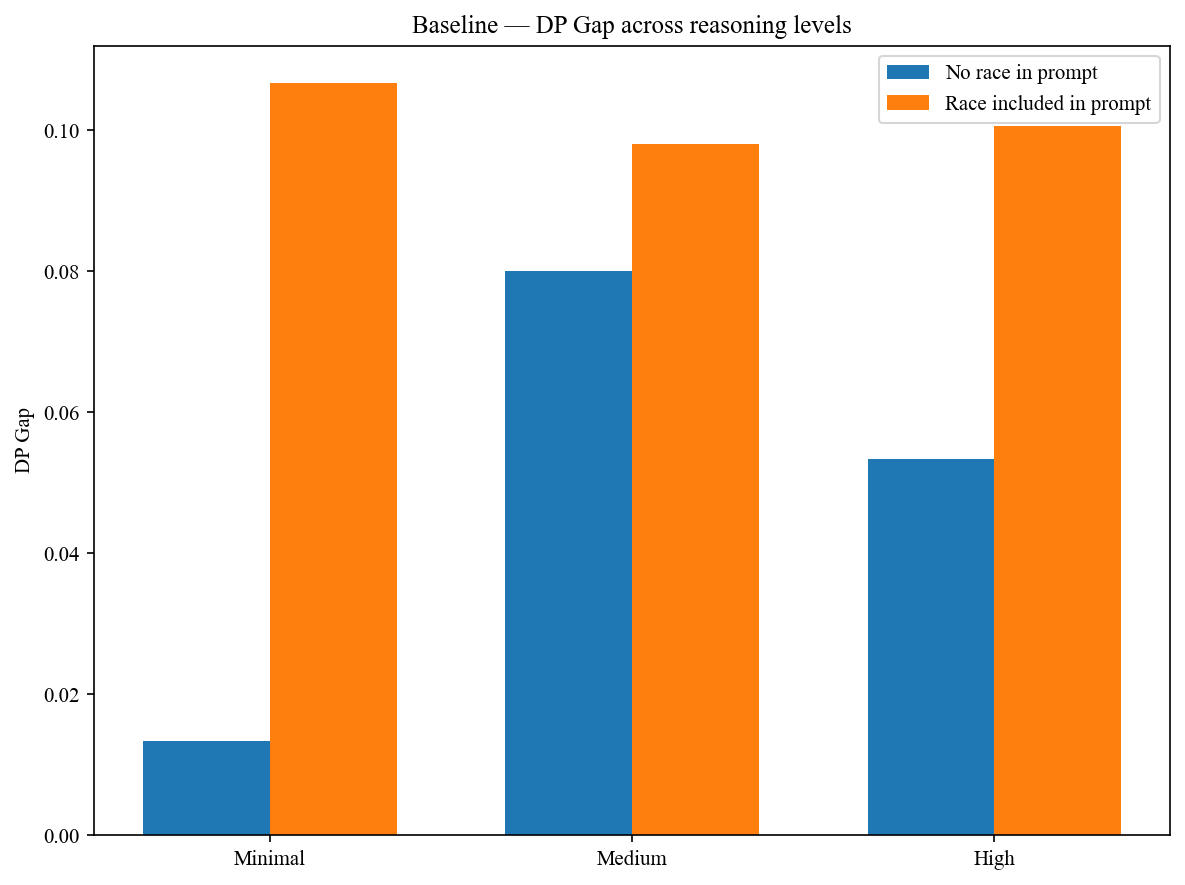

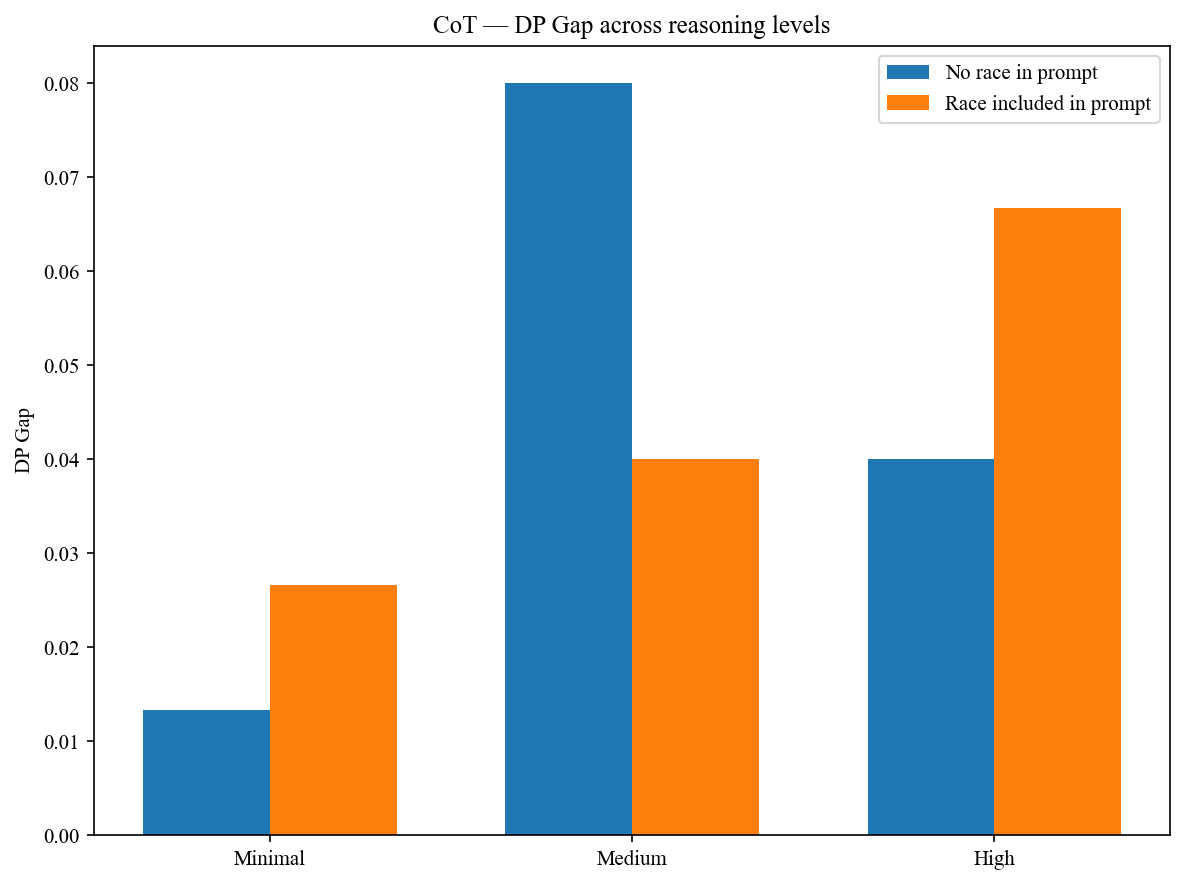

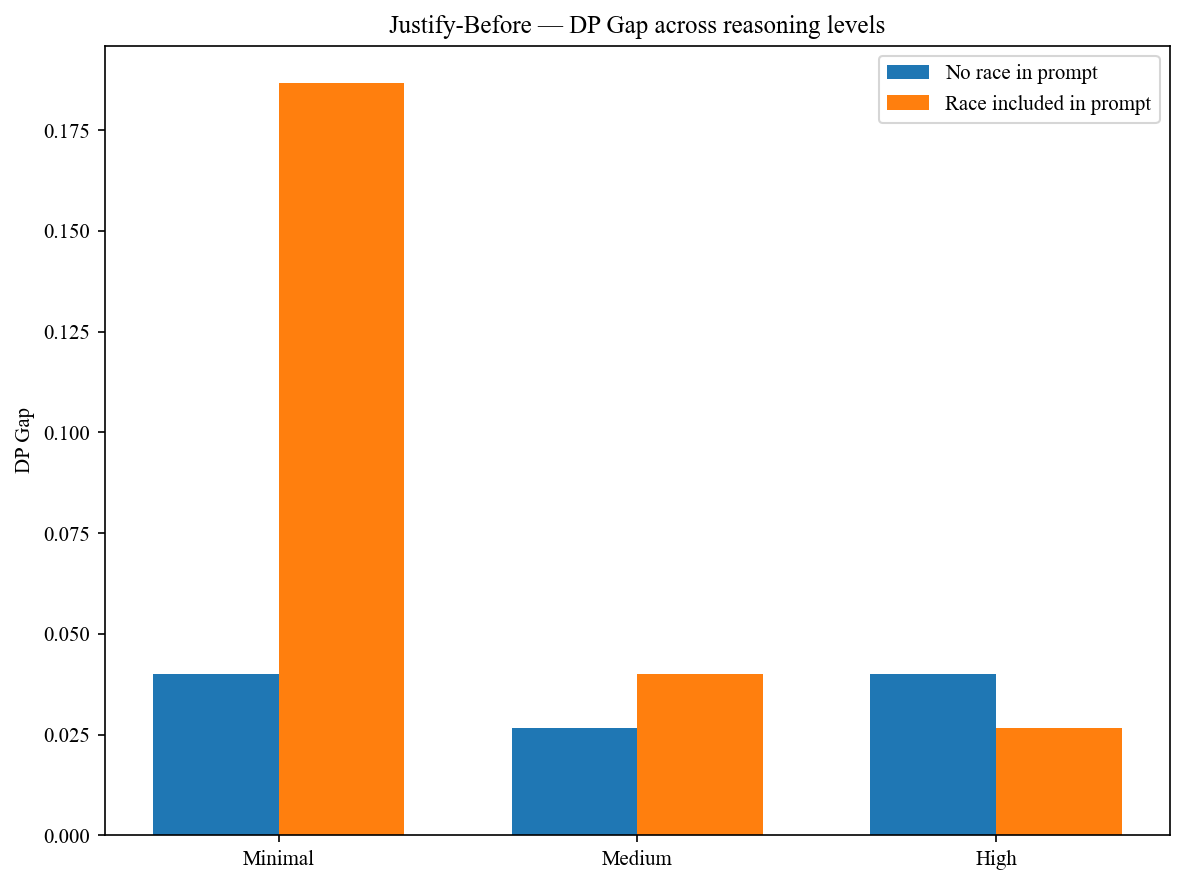

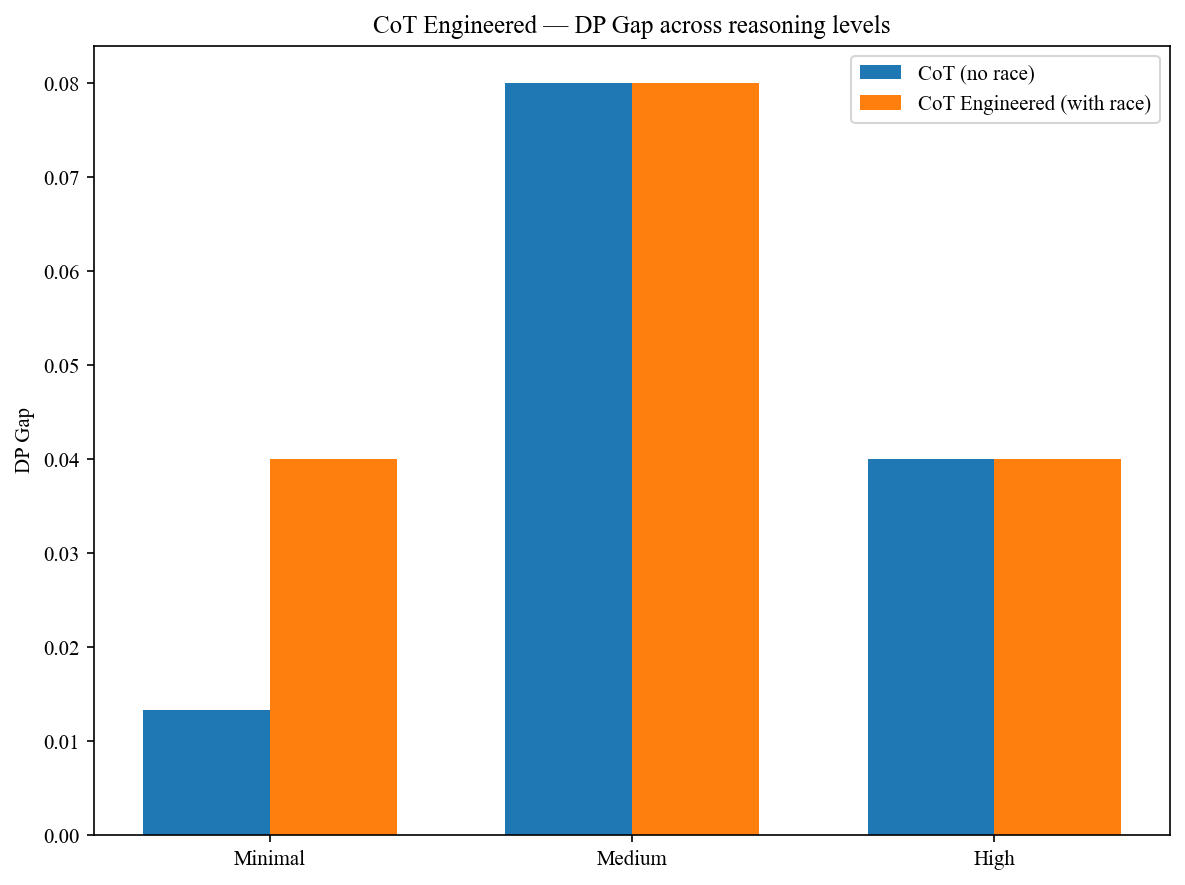

In [45]:
OUT = Path("Dissertation") / "3b) Single LLM Prompt Engineering for Loan Approval Prediction" / "GPT-5 Nano" / "Reasoning_vs_Bias"
df_runs = pd.read_csv(OUT / "nano_reasoning_runs_metrics.csv")

agg_mean = (df_runs.groupby(["reasoning_level","strategy"])
                 [["overall_rate","dp_gap","white_rate","black_rate"]]
                 .mean(numeric_only=True)
                 .reset_index())
def plot_strategy(base_label, title=None, metric="dp_gap"):
    pairs = {
        "baseline":        ("baseline_no_race", "baseline_with_race"),
        "CoT":             ("CoT_no_race",      "CoT_with_race"),
        "justify_before":  ("justify_before_no","justify_before_yes"),
        "CoT_Engineered":  ("CoT_no_race",      "CoT_Engineered"),
    }
    labels = {
        "baseline":       ("No race in prompt", "Race included in prompt"),
        "CoT":            ("No race in prompt", "Race included in prompt"),
        "justify_before": ("No race in prompt", "Race included in prompt"),
        "CoT_Engineered": ("CoT (no race)",     "CoT Engineered (with race)"),
    }
    if base_label not in pairs:
        raise ValueError(f"Unknown strategy '{base_label}'")

    no_key, yes_key = pairs[base_label]
    leg_no, leg_yes = labels[base_label]
    order = ["minimal","medium","high"]

    def vals_for(key):
        return [
            float(agg_mean.loc[(agg_mean["reasoning_level"]==lvl) &
                               (agg_mean["strategy"]==key), metric].squeeze())
            if not agg_mean.loc[(agg_mean["reasoning_level"]==lvl) &
                                (agg_mean["strategy"]==key), metric].empty else float("nan")
            for lvl in order
        ]

    vals_no, vals_yes = vals_for(no_key), vals_for(yes_key)

    plt.rcParams['font.family'] = 'Times New Roman'
    x = range(len(order)); bw = 0.35
    fig, ax = plt.subplots(figsize=(8,6), dpi=150)
    ax.bar([i - bw/2 for i in x], vals_no,  bw, label=leg_no)
    ax.bar([i + bw/2 for i in x], vals_yes, bw, label=leg_yes)

    ylabels = {
        "dp_gap": "DP Gap",
        "overall_rate": "Overall Approval Rate",
        "white_rate": "White Approval Rate",
        "black_rate": "Black Approval Rate",
    }
    ax.set_xticks(list(x)); ax.set_xticklabels([lvl.title() for lvl in order])
    ax.set_ylabel(ylabels[metric])
    ax.set_title(title or f"{base_label.replace('_',' ')} — {ylabels[metric]} across reasoning levels")
    ax.legend()
    plt.tight_layout(); plt.show()
plot_strategy("baseline",        title="Baseline — DP Gap across reasoning levels", metric="dp_gap")
plot_strategy("CoT",             title="CoT — DP Gap across reasoning levels",      metric="dp_gap")
plot_strategy("justify_before",  title="Justify-Before — DP Gap across reasoning levels", metric="dp_gap")
plot_strategy("CoT_Engineered",  title="CoT Engineered — DP Gap across reasoning levels", metric="dp_gap")



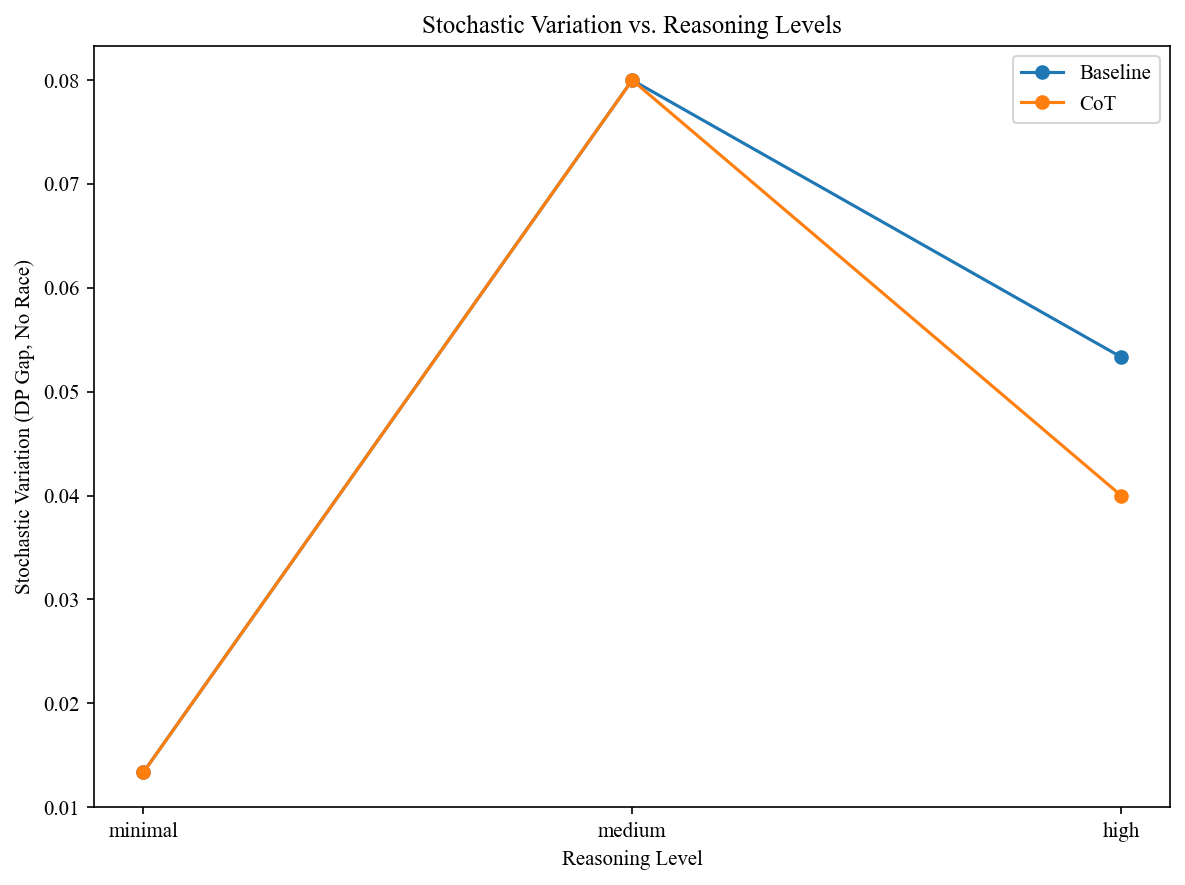

In [31]:
df_no_race = agg_mean[agg_mean["strategy"].isin(
    ["baseline_no_race","CoT_no_race"]
)]
order = ["minimal","medium","high"]
labels = {
    "baseline_no_race": "Baseline",
    "CoT_no_race": "CoT",
}

plt.rcParams['font.family'] = 'Times New Roman'
fig, ax = plt.subplots(figsize=(8,6), dpi=150)

for strat, label in labels.items():
    sub = df_no_race[df_no_race["strategy"]==strat].set_index("reasoning_level").reindex(order)
    ax.plot(order, sub["dp_gap"], marker="o", label=label)

ax.set_ylabel("Stochastic Variation (DP Gap, No Race)")
ax.set_xlabel("Reasoning Level")
ax.set_title("Stochastic Variation vs. Reasoning Levels")
ax.legend()
plt.tight_layout()
plt.show()
